## Imports and Params

In [98]:
from newsapi import NewsApiClient
from nytimesarticle import articleAPI
import pandas_datareader.data as web
import datetime
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import dateutil
import time
import quandl
from nltk.sentiment.vader import SentimentIntensityAnalyzer
from pandas.plotting import autocorrelation_plot
from pandas.tools.plotting import lag_plot
from statsmodels.tsa.ar_model import AR
from sklearn.model_selection import TimeSeriesSplit
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import TimeSeriesSplit


In [146]:
# Params
# extra API keys, comment out as necessary
#api = articleAPI("b23351c6f9314694bfe4f4929a2b72c5") 
#api = articleAPI("787bd4db8e704bbf9cebe8b7941827e0") 
api = articleAPI("f8b402f42ed14b249fd5accc95a050dd") 
#api = articleAPI("c91a676aeaef40fd844409c8b0bef485")
#api = articleAPI("c43133d654134109868299ff505e7c55")
#api = articleAPI("eb427ebc2336423ead4d350cfa4e900b")
#api = articleAPI("b538de93f1a9459da22b150d7b53cb6f")
#api = articleAPI("88f587ed149d4478b4490168d61ed9dc")

quandl.ApiConfig.api_key = "2S7d7eeL5VZrLup9pKg5"
end_date = (datetime.datetime.now() - datetime.timedelta(days=3)).isoformat()
start_date = (datetime.datetime.now() - datetime.timedelta(days=365)).isoformat()
left_sources = 'The New York Times'
right_sources = 'Fox News'
center_sources = 'Reuters AP The Wall Street Journal'
all_sources = left_sources + ' ' + right_sources + ' ' + center_sources
replace_list = ['Corp', 'Inc.', 'Inc', '.com', 'plc', ',', 'Co.']
# domain

In [169]:
def main():
    # retrieve s&p 500 companies 
    df = pd.read_csv('constituents_csv.csv')
    companies = df['Name']
    company_symb = {}

    # Iterate through companies
    # for company in companies:
    for i in range(89,90):

        company = companies.loc[i]

        # get company ticker
        company_symb[company] = df[df['Name'] == company]['Symbol']
        ticker = company_symb[company].values[0]
        
        # get rid of suffixes from company name
        for word in replace_list:
            company = company.replace(word, '')

        # Read in data
        company = 'Twitter'
        ticker='TWTR'
        print(ticker)
        print(company)
        df_master = read_in_stock_data(ticker, start_date, end_date)
        
        # Calculate 25 lags first
        for i in range(25):
            df_master['X_t-' + str(i+1)] = df_master['X_t'].shift(i+1)
            
        # Remove the ith data point because of shift
        df_master = df_master.iloc[i+1:]
        
        ###### Add in sentiment values ######
        
        # Query news articles
        trading_dates = df_master.index
        dict_master = query_news_articles(company, start_date, end_date, trading_dates, sources=all_sources)
        
        # Add sentiment columns in dataframe
        df_master['Pos_t-1'] = 0
        df_master['Neu_t-1'] = 0
        df_master['Neg_t-1'] = 0

        # iterate through dates
        for date in dict_master.keys():
            # when you enter seniment into the dataframe, use the before date not after
            average_sentiment_dict = calculate_sentiment(dict_master[date])

            # Plug this into df
            df_master.at[date,'Pos_t-1'] = average_sentiment_dict['pos']
            df_master.at[date,'Neu_t-1'] = average_sentiment_dict['neu']
            df_master.at[date,'Neg_t-1'] = average_sentiment_dict['neg']
         
         ###### Per Fold do cross validation ######
#         MSE_list_AR, coef_list_AR = cross_validate_AR(df_master)   
#         print('Mean Squared Error List:', MSE_list_AR)
#         print('Coefficient list:',coef_list_AR)
#         MSE_list_ADL, coef_list_ADL = cross_validate_ADL(df_master)
#         print('Mean Squared Error List:', MSE_list_ADL)
#         print('Coefficient list:',coef_list_ADL)
        
        df_master.to_csv('./data/'+ticker+'.csv')
        return df_master


In [170]:
main()

TWTR
Twitter
page 0
2018-04-25T11:50:09+0000
2018-03-17T14:51:39+0000
2018-04-04T17:32:57+0000
2018-03-01T22:48:50+0000
2018-02-08T14:05:20+0000
2018-01-23T15:25:00+0000
2017-11-28T16:43:34+0000
2018-01-02T21:56:28+0000
2017-11-22T10:00:23+0000
2018-02-14T15:22:40+0000
page 1
2018-04-04T09:43:16+0000
2018-03-09T00:53:33+0000
2017-10-26T13:23:26+0000
2018-05-03T21:04:39+0000
2018-04-30T23:07:35+0000
2018-02-01T17:17:01+0000
2018-05-05T02:31:32+0000
2018-04-30T18:37:32+0000
2018-04-13T21:56:34+0000
2017-11-08T10:33:46+0000
page 2
2017-10-25T09:00:04+0000
2018-05-04T19:13:45+0000
2017-10-12T11:12:16+0000
2018-05-04T07:28:38+0000
2018-05-03T20:04:36+0000
2018-05-01T15:13:47+0000
2018-02-21T16:04:34+0000
2018-05-01T21:49:35+0000
2018-05-03T00:43:32+0000
2018-05-02T01:01:41+0000
page 3
2018-05-01T01:01:32+0000
2018-05-04T18:37:11+0000
2018-04-29T11:01:32+0000
2018-05-04T21:32:47+0000
2018-05-02T11:13:11+0000
2018-05-02T09:46:06+0000
2018-05-01T22:40:21+0000
2018-05-03T14:00:06+0000
2018-05-0

page 32
2018-01-12T15:22:07+0000
2017-11-30T16:23:14+0000
2018-01-10T03:44:28+0000
2018-03-23T16:13:23+0000
2017-12-15T01:34:48+0000
2017-10-16T10:20:56+0000
2018-03-01T12:55:05+0000
2017-12-14T00:05:02+0000
2018-02-28T10:01:07+0000
2017-12-13T23:14:50+0000
page 33
2018-02-08T16:54:22+0000
2017-09-26T20:59:18+0000
2017-12-11T23:03:32+0000
2017-10-26T14:18:01+0000
2017-12-11T10:20:11+0000
2017-12-11T23:51:27+0000
2018-01-29T16:50:13+0000
2018-03-20T20:24:20+0000
2017-12-11T15:28:23+0000
2018-02-06T03:44:08+0000
page 34
2018-02-06T17:46:23+0000
2018-03-15T16:33:32+0000
2018-01-02T14:26:53+0000
2018-03-16T17:23:54+0000
2017-12-07T23:03:28+0000
2017-12-15T18:55:05+0000
2017-12-05T16:32:29+0000
2018-01-03T14:24:04+0000
2017-12-06T18:47:25+0000
2017-12-04T00:51:08+0000
page 35
2017-11-01T13:29:05+0000
2018-02-01T16:31:33+0000
2017-11-30T07:20:01+0000
2018-02-01T16:32:47+0000
2018-03-14T11:18:30+0000
2017-09-20T13:11:37+0000
2017-12-04T23:19:13+0000
2018-02-18T19:25:51+0000
2017-12-02T23:15:4

page 64
2017-12-22T19:53:37+0000
2017-10-31T11:23:34+0000
2017-07-24T17:48:43+0000
2017-10-30T11:41:57+0000
2017-07-22T12:37:37+0000
2017-07-22T17:13:56+0000
2017-09-18T16:57:01+0000
2017-10-06T10:32:09+0000
2017-08-17T17:22:17+0000
2017-09-14T15:22:44+0000
page 65
2017-07-20T16:41:52+0000
2017-07-17T14:38:23+0000
2017-10-26T11:22:36+0000
2017-08-15T13:17:18+0000
2017-10-25T11:27:44+0000
2017-09-14T16:22:13+0000
2017-10-24T11:16:20+0000
2017-07-18T16:51:32+0000
2017-11-20T21:31:30+0000
2018-03-19T09:00:07+0000
page 66
2018-03-19T12:40:58+0000
2018-03-22T02:00:00+0000
2017-08-09T18:52:22+0000
2017-08-10T16:42:09+0000
2017-09-28T10:44:21+0000
2017-09-29T10:49:38+0000
2017-08-09T08:07:48+0000
2017-06-20T13:05:14+0000
2017-10-20T11:12:25+0000
2017-06-11T13:35:14+0000
page 67
2017-06-19T22:11:53+0000
2017-07-14T06:38:53+0000
2017-09-07T16:36:14+0000
2017-07-12T09:00:36+0000
2017-06-30T12:43:51+0000
2017-10-18T11:02:23+0000
2017-09-25T11:15:49+0000
2017-10-16T11:02:09+0000
2018-04-03T00:02:0

,X_t,X_t-1,X_t-2,X_t-3,X_t-4,X_t-5,X_t-6,X_t-7,X_t-8,X_t-9,...,X_t-19,X_t-20,X_t-21,X_t-22,X_t-23,X_t-24,X_t-25,Pos_t-1,Neu_t-1,Neg_t-1
Date,,,,,,,,,,,,,,,,,,,,,
2017-06-14,16.76,16.97,17.04,16.90,17.59,17.44,17.57,18.23,18.31,18.53,...,18.51,18.28,19.49,19.23,18.61,18.39,18.54,0.080962,0.772667,0.146397
2017-06-15,16.83,16.76,16.97,17.04,16.90,17.59,17.44,17.57,18.23,18.31,...,18.35,18.51,18.28,19.49,19.23,18.61,18.39,0.204333,0.795667,0.000000
2017-06-16,16.67,16.83,16.76,16.97,17.04,16.90,17.59,17.44,17.57,18.23,...,18.43,18.35,18.51,18.28,19.49,19.23,18.61,0.000000,0.881000,0.119000
2017-06-19,17.06,16.67,16.83,16.76,16.97,17.04,16.90,17.59,17.44,17.57,...,18.15,18.43,18.35,18.51,18.28,19.49,19.23,0.000000,0.732667,0.267333
2017-06-20,16.91,17.06,16.67,16.83,16.76,16.97,17.04,16.90,17.59,17.44,...,17.98,18.15,18.43,18.35,18.51,18.28,19.49,0.077750,0.789000,0.133250
2017-06-21,17.78,16.91,17.06,16.67,16.83,16.76,16.97,17.04,16.90,17.59,...,17.95,17.98,18.15,18.43,18.35,18.51,18.28,0.074000,0.866000,0.059667
2017-06-22,18.15,17.78,16.91,17.06,16.67,16.83,16.76,16.97,17.04,16.90,...,18.23,17.95,17.98,18.15,18.43,18.35,18.51,0.000000,1.000000,0.000000
2017-06-23,18.50,18.15,17.78,16.91,17.06,16.67,16.83,16.76,16.97,17.04,...,18.23,18.23,17.95,17.98,18.15,18.43,18.35,0.069500,0.804250,0.126250
2017-06-26,18.29,18.50,18.15,17.78,16.91,17.06,16.67,16.83,16.76,16.97,...,18.43,18.23,18.23,17.95,17.98,18.15,18.43,0.000000,1.000000,0.000000


In [81]:
def main_read_in_csv(ticker):
    df_master = pd.read_csv('./data/'+ticker+'.csv',index_col='Date')
    
    ###### Per Fold do cross validation ######
    MSE_list_AR, coef_AR, intercept_AR, best_AR_train_index, best_AR_test_index = cross_validate_AR(df_master)   
    print('Mean Squared Error List:', MSE_list_AR)
    print('Best Coefficient',coef_AR)
    print('Best Intercept', intercept_AR)
    MSE_list_ADL, coef_ADL, intercept_ADL, best_ADL_train_index, best_ADL_test_index = cross_validate_ADL(df_master)
    print('Mean Squared Error List:', MSE_list_ADL)
    print('Best Coefficients:',coef_ADL)
    print('Best Intercept', intercept_ADL)
    
    return MSE_list_AR, MSE_list_ADL, intercept_AR, intercept_ADL, coef_AR, coef_ADL,\
           best_AR_train_index, best_AR_test_index, best_ADL_train_index, best_ADL_test_index


In [156]:
def plot_AR_model(ticker):
    # Plot for AR model
    df = pd.read_csv('./data/'+ticker+'.csv',index_col='Date')
    X = df.loc[:, df.columns !='X_t']
    Y = df['X_t']
    X_train, X_test = X.iloc[best_AR_train_index,:], X.iloc[best_AR_test_index,:]
    Y_train, Y_test = Y.iloc[best_AR_train_index], Y[best_AR_test_index]

    # find optimal lag period
    lag = get_lag_period(Y_train)

    # filter the lags and sentiment values
    X_train = X_train.iloc[:,range(lag-1)]
    X_test = X_test.iloc[:,range(lag-1)]

    # Fit the model
    LinReg = LinearRegression(normalize=True)
    LinReg.fit(X_train,Y_train)
    Y_pred = LinReg.predict(X_test)

    # Plot
    Y_plot = Y_test.copy(deep=True)
    Y_plot = Y_plot.to_frame()
    Y_plot['Predicted'] = pd.Series(Y_pred, index=Y_plot.index)
    Y_plot.columns = ['Actual', 'Predicted']

    plt.figure(figsize=(10,10))
    plt.title('Predicted Vs. Actual Plot AR model')
    plt.xlabel('Date')
    plt.ylabel('Price')
    plt.plot(Y_plot.index, Y_plot['Actual'], label='Actual')
    plt.plot(Y_plot.index, Y_plot['Predicted'],label='Predicted')
    plt.legend()

    plt.show()

In [158]:
def plot_ADL_model(ticker):
    # Plot for ADL model
    df = pd.read_csv('./data/'+ticker+'.csv',index_col='Date')
    X = df.loc[:, df.columns !='X_t']
    Y = df['X_t']
    X_train, X_test = X.iloc[best_ADL_train_index,:], X.iloc[best_ADL_test_index,:]
    Y_train, Y_test = Y.iloc[best_ADL_train_index], Y[best_ADL_test_index]

    # find optimal lag period
    lag = get_lag_period(Y_train)

    # filter the lags and sentiment values
    X_train = X_train.iloc[:,range(lag-1)]
    X_test = X_test.iloc[:,range(lag-1)]

    # Add in the sentiment values
    X_train['Pos_t-1'] = df.iloc[best_ADL_train_index,-3]
    X_train['Neu_t-1'] = df.iloc[best_ADL_train_index,-2]
    X_train['Neg_t-1'] = df.iloc[best_ADL_train_index,-1]

    X_test['Pos_t-1'] = df.iloc[best_ADL_test_index,-3]
    X_test['Neu_t-1'] = df.iloc[best_ADL_test_index,-2]
    X_test['Neg_t-1'] = df.iloc[best_ADL_test_index,-1]

    X_train = X_train.fillna(0)
    X_test = X_test.fillna(0)

    # Fit the model
    LinReg = LinearRegression(normalize=True)
    LinReg.fit(X_train,Y_train)
    Y_pred = LinReg.predict(X_test)

    # Plot
    Y_plot = Y_test.copy(deep=True)
    Y_plot = Y_plot.to_frame()
    Y_plot['Predicted'] = pd.Series(Y_pred, index=Y_plot.index)
    Y_plot.columns = ['Actual', 'Predicted']

    plt.figure(figsize=(10,10))
    plt.title('Predicted Vs. Actual Plot ADL model')
    plt.xlabel('Date')
    plt.ylabel('Price')
    plt.plot(Y_plot.index, Y_plot['Actual'], label='Actual')
    plt.plot(Y_plot.index, Y_plot['Predicted'],label='Predicted')
    plt.legend()

    plt.show()


In [66]:
def cross_validate_AR(df):
    """ Runs the backtest with k fold cross validation for AR model
    Params:
        df (pd.Dataframe): Dataframe with X_t, lags, and sentiment score
    Returns:
        MSE_list (list): List of MSE per fold of cross-validation
        coef_list (list): List of coef per fold of cross-validation
        best_train_index (list): Indices of the train index with best MSE
        best_test_index (list): Indicies of test index with best MSE
    """
    tscv = TimeSeriesSplit(n_splits=8)
    X = df.loc[:, df.columns !='X_t']
    Y = df['X_t']
    
    MSE_list = []
    coef_list = []
        
    for train_index, test_index in tscv.split(X):
        X_train, X_test = X.iloc[train_index,:], X.iloc[test_index,:]
        Y_train, Y_test = Y.iloc[train_index], Y[test_index]
        
        # find optimal lag period
        lag = get_lag_period(Y_train)

        # filter the lags and sentiment values
        X_train = X_train.iloc[:,range(lag-1)]
        X_test = X_test.iloc[:,range(lag-1)]

        MSE, coef, intercept = fit_and_run_regression(X_train, Y_train, X_test, Y_test)
        
        # Check to see if this MSE is the best or not
        if all(i >= MSE for i in MSE_list):
            coef_best = coef
            best_train_index = train_index
            best_test_index = test_index
        MSE_list.append(MSE)
        
    return MSE_list, coef_best, intercept, best_train_index, best_test_index


In [67]:
def cross_validate_ADL(df):
    """ Runs the backtest with k fold cross validation for ADL model
    Params:
        df (pd.Dataframe): Dataframe with X_t, lags, and sentiment score
    Returns:
        MSE_list (list): List of MSE per fold of cross-validation
        coef_best (list): List of coef per fold of cross-validation
        best_train_index (list): Indices of the train index with best MSE
        best_test_index (list): Indicies of test index with best MSE
        
    """
    tscv = TimeSeriesSplit(n_splits=8)
    X = df.loc[:, df.columns !='X_t']
    Y = df['X_t']
    
    MSE_list = []
    coef_list = []
        
    for train_index, test_index in tscv.split(X):
        X_train, X_test = X.iloc[train_index,:], X.iloc[test_index,:]
        Y_train, Y_test = Y.iloc[train_index], Y[test_index]
        
        # find optimal lag period
        lag = get_lag_period(Y_train)

        # filter the lags and sentiment values
        X_train = X_train.iloc[:,range(lag-1)]
        X_test = X_test.iloc[:,range(lag-1)]
        
        # Add in the sentiment values
        X_train['Pos_t-1'] = df.iloc[train_index,-3]
        X_train['Neu_t-1'] = df.iloc[train_index,-2]
        X_train['Neg_t-1'] = df.iloc[train_index,-1]
        
        X_test['Pos_t-1'] = df.iloc[test_index,-3]
        X_test['Neu_t-1'] = df.iloc[test_index,-2]
        X_test['Neg_t-1'] = df.iloc[test_index,-1]
        
        X_train = X_train.fillna(0)
        X_test = X_test.fillna(0)

        MSE, coef, intercept = fit_and_run_regression(X_train, Y_train, X_test, Y_test)
        
        # Check to see if this MSE is the best or not
        if all(i >= MSE for i in MSE_list):
            coef_best = coef
            best_train_index = train_index
            best_test_index = test_index
        MSE_list.append(MSE)

        
    return MSE_list, coef_best, intercept, best_train_index, best_test_index


In [47]:
a_list = []
all(i >= 30 for i in a_list)

True

### Methods Used for Data Collection

In [35]:
def calculate_sentiment(sentence_arr):
    """ Returns the average sentiment of the array
    Params:
        sentence_arr(Array): Array of setences that we have to calculate
        the sentiment of.
    Returns:
        sentiment (dictionary): Takes the average of all sentences
        format of score is {'neg': 0.0, 'neu': 1.0, 'pos': 0.0, 'compound': 0.0}
    """
    sia = SentimentIntensityAnalyzer()
    df = df = pd.DataFrame(columns=['neg','neu','pos','compound'])
    for sentence in sentence_arr:
        sentiment = sia.polarity_scores(sentence)
        df_sentiment = pd.DataFrame([sentiment], columns=sentiment.keys())
        df = df.append(df_sentiment)
    
    avg_sentiment = dict(df.mean())    
    return avg_sentiment 

In [168]:
def query_news_articles(company, start_date, end_date, trading_dates, sources):
    """ Queries news article for a certain time frame and split it by dates
        Note that
    Params:
        company (String): Name of company
        start_date (String): Start date in format of "2001-12-31"
        end_date (String): End date in format of "2001-12-31"
         trading_dates (Array of Strings): Array of dates when the market was open
                 dates in format of "2001-12-31"
        sources (Array of Strings): Array of different news sources
    Returns:
        company_dic (dictionary): keys are date, values are array of headlines
    """
    company_dict = {k: [] for k in trading_dates.date}
    start_date = int(start_date.replace("-","").split('T')[0])
    ending_date = (dateutil.parser.parse(end_date)-datetime.timedelta(days=1)).isoformat()
    end_date = int(ending_date.replace("-","").split('T')[0])
    newsdata = api.search(q=company, begin_date = start_date,
                           end_date = end_date,
                          fq='headline:('+company+ ') OR body:('+company+') AND source:(' + sources + ')',
                          page = 0,
                          facet_filter = True)
                               

    #print(newsdata) # newsdata is full HTTP response
    number_of_hits = newsdata['response']['meta']['hits']
    number_of_pages = (number_of_hits // 10) + 1
    
    time.sleep(1)
    # page through results and add headlines to companY_dict
    for i in range(0, min(number_of_pages,100)):
        print('page', i)
        newsdata = api.search(q=company, begin_date = start_date,
                           end_date = end_date,
                          fq='headline:('+company+ ') OR body:('+company+') AND source:(' + sources + ')',
                          page = i,
                          facet_filter = True)
        articles = newsdata['response']['docs']
        for article in articles:
            relevance = article['score']
            if relevance >= 0.005: 
                headline = article['headline']['main']
                blurb = article['snippet']
                # print(article['pub_date'], '\t', article['headline']['main'])
            
                # description = article['description']
                # format of date is 2018-04-13T00:46:59Z (UTC format)
                publish_date = article['pub_date'] 
                print(publish_date)
                # adjust date for trading day
                publish_date, publish_time = publish_date.split('T')
                date_arr = publish_date.split('-')
                publish_datetime = datetime.date(int(date_arr[0]), int(date_arr[1]), int(date_arr[2]))
                time_arr = publish_time[:-1].split(':')
                # stock market closes at 4:00 PM EST; if article published after 
                # 16:00:00+4:00:00 = 20:00:00 UTC headline affects next trading day;
                # otherwise affects current trading day
                trading_datetime = publish_datetime
                if int(time_arr[0]) >= 20:
                    trading_datetime += datetime.timedelta(days=1)
                
                # if given trading_date invalid (ie if article published on Friday 
                # after market close, Saturday, or Sunday before 4 pm est) push trading_date
                # to the following Monday (ie first valid trading_date)
                while trading_datetime not in trading_dates:
                    trading_datetime += datetime.timedelta(1)
                company_dict[trading_datetime].append(headline)
                # company_dict[trading_datetime].append(blurb) include 'snippet' in sentiment analysis
        time.sleep(1)
        
    return company_dict

In [37]:
def get_lag_period(X_train):
    """ Finds the optimal lab period given a ticker and the start date and end date
    Params:
        X_train (df): Training data used to calculate lag back
    Returns:
        lag (int): Number of lag periods
    """
    model = AR(X_train)
    model_fit = model.fit()
    lag = model_fit.k_ar
    
    return lag
    

In [38]:
def read_in_stock_data(ticker, start_date, end_date):
    """ Initializes a data frame for a certain ticker
    Params:
        ticker (String): Stock ticker to be analyzed
        start_date (String): Start date in format of "2001-12-31"
        end_date (String): End date in format of "2001-12-31"
        lag (int): Number of lag periods
    Returns:
        dataframe (pd.Dataframe): Dataframe with index 'Date' and column 'X_t'
    """
    # Get the data in a dataframe
    dataframe = web.DataReader(ticker, 'morningstar', start_date, end_date)['Close']
    dataframe = pd.Series.to_frame(dataframe)
    dataframe.reset_index(level=0, drop=True, inplace=True)
    dataframe.columns = ['X_t']
    return dataframe

In [59]:
def fit_and_run_regression(X_train, Y_train, X_test, Y_test, doprint=False):
    """ Fits the model with train and test data
    Params:
        X_train (pd.Dataframe): X training data
        Y_train (pd.Dataframe): Y training data
    Returns:
        MSE (float): Mean Squared Error 
    """
    LinReg = LinearRegression(normalize=True)
    LinReg.fit(X_train,Y_train)
    Y_pred = LinReg.predict(X_test)
    MSE = mean_squared_error(Y_test, Y_pred)
    coefficients = LinReg.coef_
    intercept = LinReg.intercept_
    if doprint:
        print("R^2 Value: %.2f" %LinReg.score(X_test, Y_test))
        print("Mean squared error: %.2f "% MSE)
        print("Coefficients for the Regression are: " ,coefficients)
    
    return MSE, coefficients, intercept

## Run this Michelle to get the things you need

Mean Squared Error List: [159.4183479635119, 95.50380299346179, 79.00723282549399, 113.46570501820837, 133.04417043319432, 427.6792641050929, 474.5908913701479, 1028.0550184959343]
Best Coefficient [ 1.01685738  0.01410518 -0.1233978  -0.00854147  0.04527946  0.11665809
 -0.20137102  0.08092797  0.03345012  0.08343178  0.01744185 -0.17274653
  0.06505309]
Best Intercept -5.393893871255955
Mean Squared Error List: [161.38500372891977, 99.2708821576964, 77.67901730197391, 115.2506018450423, 139.52992609744152, 421.9380623281069, 488.16592768063583, 1035.00684476251]
Best Coefficients: [ 1.02080025e+00  6.35657877e-03 -1.14783545e-01 -9.40287957e-03
  4.25645976e-02  1.11665891e-01 -1.98374855e-01  7.27233123e-02
  5.81349223e-02  5.39403408e-02  2.37522706e-02 -1.70315459e-01
  7.12671076e-02 -1.11492046e+01  4.35112837e+00 -1.25953794e+01]
Best Intercept -5.258860126550985


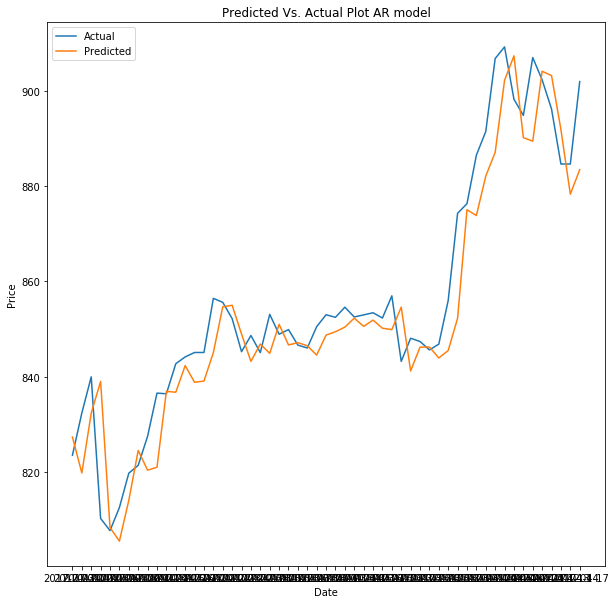

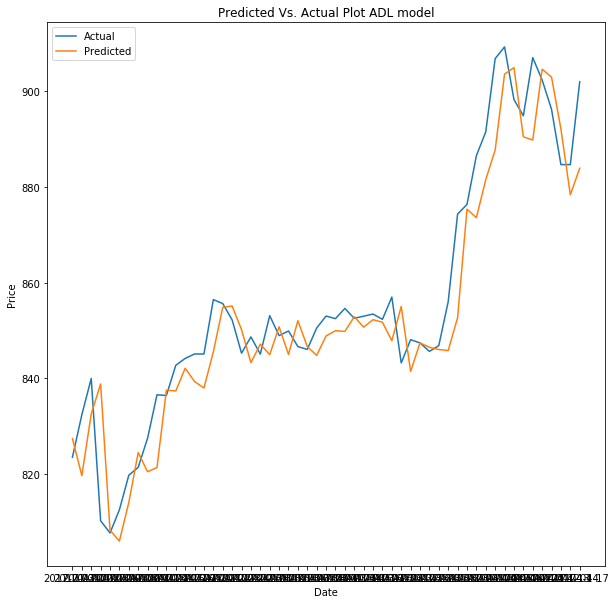

In [159]:
# How to get everything for the website
ticker = 'AMZN'

MSE_list_AR, MSE_list_ADL, intercept_AR, intercept_ADL, coef_AR, coef_ADL,\
           best_AR_train_index, best_AR_test_index, best_ADL_train_index, best_ADL_test_index = main_read_in_csv(ticker)
model_AR = LinearRegression(normalize=True)
model_AR.intercept_ = intercept_AR
model_AR.coef_ = coef_AR

plot_AR_model(ticker)
plot_ADL_model(ticker)
